## Capítulo 8

In [50]:
from sympy.physics.mechanics import ReferenceFrame,Point,dynamicsymbols
from sympy.physics.mechanics import Point,RigidBody,inertia, KanesMethod
from sympy import latex,pprint,symbols,init_printing
from sympy.algebras.quaternion import Quaternion
import numpy as np
import sys 
sys.path.append("../tools")
from vis import Visualizer
%matplotlib notebook
init_printing() # Para visualizar simbolos


<IPython.core.display.Javascript object>


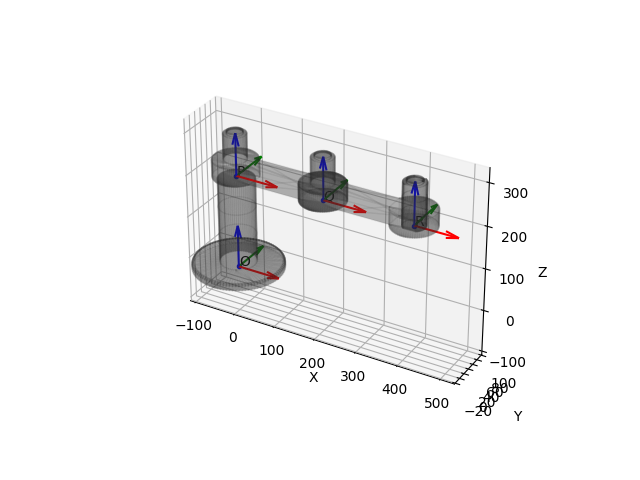

In [3]:
# Definicion del modelo para el ejemplo del robot scara

# Parametros del modelo
l1,l2,l3,rb,rc=symbols('l_1,l_2,l_3,r_b,r_c')
# Parametros inerciales (note que se usan las variables ib e ic  para la inercia en z).
mb,mc,ib,ic=symbols('m_b,m_c,i_b,i_c') 
# Variables de movimiento
q1,q2=dynamicsymbols('q_1,q_2')

# Defina los marcos y puntos de interes en el robot
a=ReferenceFrame('A')
o=Point('O')
b=a.orientnew('B','Axis',(q1,a.z))
p=o.locatenew('P',l1*a.z)
bstar=p.locatenew('Bstar',rb*b.x)
c=b.orientnew('C','Axis',(q2,b.z))
q=p.locatenew('Q',l2*b.x)
cstar=q.locatenew('Cstar',rc*c.x)
r=q.locatenew('R',l3*c.x)

# Defina los cuerpos rígidos 
#RigidBody(name, masscenter, frame, mass, inertia)
inertia_b=inertia(b,0,0,ib)
inertia_c=inertia(c,0,0,ic)
body_b=RigidBody('B', bstar, b, mb, (inertia_b,bstar))
body_c=RigidBody('C', cstar, c, mc, (inertia_c,cstar))

# Construya un objecto de visualizacion con el marco de referencia inercial y punto de origen
vis=Visualizer(a,o)
# Agrege marcos y puntos para ser visualizados (marco,punto,geometria)
vis.add(a,o,shape='../Visualizacion/assets/scara_base.stl')
vis.add(b,p,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,q,shape='../Visualizacion/assets/scara_brazo.stl')
vis.add(c,r,shape='../Visualizacion/assets/scara_cilindro.stl')

#vis.add(b,o,shape='assets/Atraccion_Parque_link1.stl')
#vis.add(c,p,shape='assets/Atraccion_Parque_disk.stl')
vis.add(a,o,frame_scale=100)
vis.add(b,p,frame_scale=100)
vis.add(c,q,frame_scale=100)
vis.add(c,r,frame_scale=100)


# Modifique las variables de movimiento y verifique el cambio en la posicion y
# orientacion de los marcos
vis.plot({l1:220,l2:210,l3:210,q1:0,q2:0})

In [ ]:
## 8.1 Ecuaciones iterativas de Newton-Euler

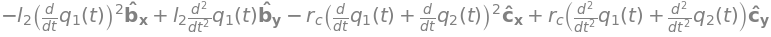

In [4]:
# Primero calcule la cinemática de los cuerpos
# Para esto defina las velocidades de los puntos en cada marco de referencia
p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)


# Una vez definidas las velocidades puede calcular las velocidades en en marco A
# Verifique los resultados con los siguientes comandos
#b.ang_vel_in(a)
#c.ang_vel_in(a)
#b.ang_acc_in(a)
#c.ang_acc_in(a)
#bstar.vel(a)
#cstar.vel(a)
#bstar.acc(a)
cstar.acc(a)


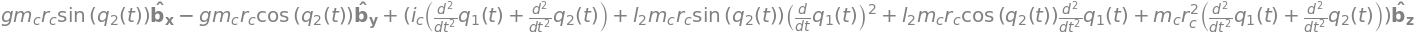

In [25]:
#Usando ecuaciones de Newton-Euler (F=ma, M=Icm*alpha+ w x Icm w)
# desde el último objeto en la cadena cinemática puede analizar y resolver
# la cinética.

#Primero para el cuerpo C
# Encuentre la fuerza de reacción F_bc: sum(Fc)=,
F_bc=mc*g*a.z+mc*cstar.acc(a)
# 
M_bc=q.pos_from(c_star).cross(F_bc)+body_c.angular_momentum(cstar,a).dt(a)
M_bc.express(b).simplify()

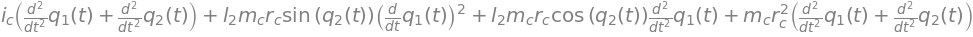

In [22]:
#Calcule el momento asociado al motor
M2=M_bc.express(b).dot(b.z)
M2

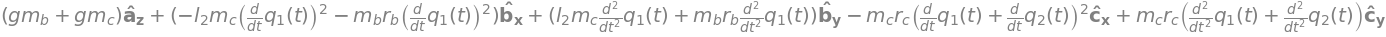

In [30]:
#Ahora de la sumatoria de fuerzas para el cuerpo B
F_ab=mb*g*a.z+mb*bstar.acc(a)+F_bc
F_ab

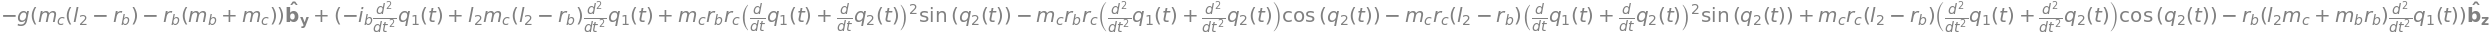

In [45]:
# Y de la sumatoria de momentos para el cuerpo B
M_ab=-q.pos_from(bstar).cross(-F_bc)\
+p.pos_from(bstar).cross(F_ab)\
-body_b.angular_momentum(bstar,a).dt(a)
M_ab.express(b).simplify()

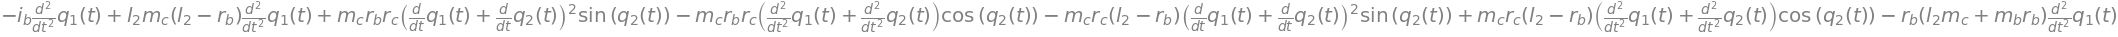

In [46]:
#Calcule el momento asociado al motor
#TODO REVISAR
M_ab.dot(b.z).simplify()

In [47]:
## 8.2 Formulacion de Kane para sistemas multicuerpo


In [63]:
u1,u2=dynamicsymbols('u1,u2')
q1d,q2d,u1d,u2d=dynamicsymbols('q1 q2 u1 u2',1)


p.set_vel(a,0)
q.set_vel(b,0)
cstar.set_vel(c,0)
bstar.set_vel(b,0)
q.v2pt_theory(p,a,b)
bstar.v2pt_theory(p,a,b)
cstar.v2pt_theory(q,b,c)
cstar.v2pt_theory(q,a,c)
b.set_ang_vel(a,u1*a.z)
c.set_ang_vel(b,u2*a.z)


kd = [q1d-u1, q2d-u2]
km=KanesMethod(a,q_ind=[q1,q2],u_ind=[u1,u2],kd_eqs=kd)

NonInvertibleMatrixError: Matrix det == 0; not invertible.